# Advanced Statistical Inference -- Variational Inference for Bayesian Logistic Regression

In this notebook, you will learn how to implement the (stochastic) variational inference algorithm.

**NOTE:** In this notebook we will heavily rely on [PyTorch](https://pytorch.org/). Syntax is pretty similar to numpy's for what we need to do -- don't worry.
The main different is the programming style, much more object oriented. If you are not familiar with OOP, the Internet is a [good friend](https://lmgtfy.com/?q=oop+python). 

This gist will serve you as a refresh on Variational Inference (VI).
In the general setting, given a probabilistic model with observations $\{\mathbf{X},\mathbf{y}\}$, model parameters $\mathbf{w}$ and likelihood $p(\mathbf{y}|\mathbf{X}, \mathbf{w})$, by introducing an approximate posterior distribution $q_\theta(\mathbf{w})$ with parameters $\theta$, the variational lower bound to the log-marginal likelihood is defined as


\begin{align} 
  \mathrm{KL}[{q_\theta(\mathbf{w})}||{p(\mathbf{w}|\mathbf{X},\mathbf{y})}] & = 
      \mathbb{E}_{q_{\theta}} \left[ \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathbf{X}, \mathbf{y})} \right] =  \nonumber \\
  & =   \mathbb{E}_{q_{\theta}}\left[\log q_{\theta}(\mathbf{w}) - \log p(\mathbf{w}|\mathbf{X}, \mathbf{y})\right] = \nonumber \\
  & =   \mathbb{E}_{q_{\theta}}\left[-\log p(\mathbf{y}|\mathbf{X}, \mathbf{w})\right] + \mathbb{E}_{q_{\theta}}\left[\log q_{\theta}(\mathbf{w}) - \log p(\mathbf{w}) \right] + \log p(\mathbf{y}|\mathbf{X}) = \nonumber \\
  & =  -\mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w}) +  \mathrm{KL}[{q_{\theta}(\mathbf{w})}||{p(\mathbf{w})}] + \log p(\mathbf{y}|\mathbf{X}) 
\end{align}


The previous derivation shows that minimizing the KL divergence between the approximate posterior and the true posterior is equivalent to minimizing the so-called Negative Expected Lower Bound (NELBO).
This also shows that when the approximate posterior is exactly equal to the true posterior, the NELBO is equal to the negative log-marginal likelihood.  

The objective is then to minimize this variational bound:

\begin{align}
      \mathcal{L}(\theta) = -\underbrace{\mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w})}_\text{Expected loglikelihood} +  \mathrm{KL}[{q_{\theta}(\mathbf{w})}||{p(\mathbf{w})}]
\end{align}

The analytic evaluation of the NELBO is generally still untractable due to the presence of the expected loglikelihood under the variational distribution (in the majority of the cases the rightmost KL is tractable).
This is commonly overcome by sampling $N_\mathrm{MC}$ times from $q_\theta$ 
\begin{align}
    \label{eq:expected-loglikelihood}
    \mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w}) \approx \dfrac{1}{N_\mathrm{MC}} \sum_{\tilde{\mathbf{w}}_i\sim q_\theta} \log p(\mathbf{y}|\mathbf{X}, \tilde{\mathbf{w}}_i)
\end{align}

In case of large datasets, even this formulation can be computationally challenging, due to the evaluation of the likelihood $N_\mathrm{MC}$ times.
Nonetheless, assuming fully factorization on the likelihood, this quantity can be approximated even further using mini-batching.
Let $\mathcal{D}$ be the dataset made of $N$ examples, taking a random subset $\mathcal{B} \subset \mathcal{D}$, the approximation becomes

\begin{align}
    \mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w} \approx \dfrac{1}{N_\mathrm{MC}} \frac{N}{|\mathcal{B}|}\sum_{\tilde{\mathbf{w}}_i\sim q_\theta} \sum_{\mathbf{X}_j, \mathbf{y}_j\sim\mathcal{B}} \log p(\mathbf{y}_j|\mathbf{X}_j, \tilde{\mathbf{w}}_i)
\end{align}



# 1. Setup and data

Similarly to the previous lab, you’re going to implement the VI algorithm described in the lecture for binary classification.


In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as scipy
import scipy.spatial
import time 

import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import pandas as pd
import torch
import torch.nn as nn

warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def args_as_tensors(*index):
    """A simple decorator to convert numpy arrays to torch tensors"""
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i, a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

Let's start by defining some probability distributions that we will need in this notebook. 
First, the Bernoulli distribution. 

**Exercise:**
Complete the following class to compute the logdensity of the Bernoulli distribution 

(*Hint:* check the previous lab for the solution) (*Hint 2:* to avoid NaN while computing logs, add a small positive constant, e.g. jitter, to the logs)

In [2]:
jitter = 1e-10

class Distribution(nn.Module):  
    pass

class Bernoulli(Distribution):
    @args_as_tensors(1, 2)
    def logdensity(self, y, p):
        return y*torch.log(p+jitter) + (1-y)*torch.log(1-p+jitter) #A REMPLIR

**Exercise:** 
Now let's move to the Gaussian distribution. Similarly for what we did on the GP lab, note that the parameter $\sigma^2$ is always expected to be positive. It is possible that the optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. A commonly-used technique to enforce this condition is to work with a transformed version of parameters using the logarithm transformation. In particular, define $\psi = \log\sigma^2$. So remember to take the exponential of $\psi$ if you want to use $\sigma^2$.

In [3]:
class NormalDiagonal(Distribution):
    @property
    def var(self):
        return self.logvar.exp()
    
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalDiagonal, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.logvar = nn.Parameter(torch.zeros(d), requires_grad=train)
    
    def sample(self, n=1):
        eps = torch.randn(n,self.d,requires_grad=self.train) 
        samples = self.mean + eps*(torch.sqrt((self.var)))
        #shape:[n, self.d]
        return samples

# 2. KL Divergence

Run the cell below -- there are a couple of helper functions that will make the notebook lighter for coding. 

In [4]:
from functools import total_ordering

_KL_REGISTRY = {}  # Source of truth mapping a few general (type, type) pairs to functions.
_KL_MEMOIZE = {}  # Memoized version mapping many specific (type, type) pairs to functions.

@total_ordering
class _Match(object):
    __slots__ = ['types']

    def __init__(self, *types):
        self.types = types

    def __eq__(self, other):
        return self.types == other.types

    def __le__(self, other):
        for x, y in zip(self.types, other.types):
            if not issubclass(x, y):
                return False
            if x is not y:
                break
        return True

def _dispatch_kl(type_q, type_p):
    matches = [(super_q, super_p) for super_q, super_p in _KL_REGISTRY
               if issubclass(type_q, super_q) and issubclass(type_p, super_p)]
    if not matches:
        return NotImplemented
    left_q, left_p = min(_Match(*m) for m in matches).types
    right_p, right_q = min(_Match(*reversed(m)) for m in matches).types
    left_fun = _KL_REGISTRY[left_q, left_p]
    right_fun = _KL_REGISTRY[right_q, right_p]
    if left_fun is not right_fun:
        logger.warning('Ambiguous kl_divergence({}, {}). Please register_kl({}, {})'.format(
            type_q.__name__, type_p.__name__, left_q.__name__, right_p.__name__))
    return left_fun


def register_kl(type_q, type_p):
    """
    Decorator to register a pairwise function with kl_divergence.
    Usage:

        @register_kl(Normal, Normal)
        def kl_normal_normal(q, p):
            # insert implementation here
    """
    if not isinstance(type_q, type) and issubclass(type_q, BaseDistribution):
        raise TypeError('Expected type_q to be a Distribution subclass but got {}'.format(type_q))
    if not isinstance(type_p, type) and issubclass(type_p, BaseDistribution):
        raise TypeError('Expected type_p to be a Distribution subclass but got {}'.format(type_p))
    
    def decorator(fun):
        _KL_REGISTRY[type_q, type_p] = fun
        _KL_MEMOIZE.clear()  # reset since lookup order may have changed
        print('KL divergence between \'%s\' and \'%s\' registered.' % (type_q.__name__, type_p.__name__))
        return fun
    return decorator


def kl_divergence(q, p):
    r"""Compute Kullback-Leibler divergence KL(p|q) between two distributions."""
    try:
        fun = _KL_MEMOIZE[type(q), type(p)]
    except KeyError:
        fun = _dispatch_kl(type(q), type(p))
        _KL_MEMOIZE[type(q), type(p)] = fun
    if fun is NotImplemented:
        raise NotImplementedError('KL divergence for pair %s - %s not registered' % (type(q).__name__,
                                                                                     type(p).__name__))
    return fun(q, p)

The expression of the KL divergence between multivariate Gaussians $q = \mathcal{N}(\mathbf{\mu}_q, \Sigma_q)$ and $p = \mathcal{N}(\mathbf{\mu}_p, \Sigma_p)$ is as follows:

\begin{equation}
\mathrm{KL}[q || p] = 
\frac{1}{2} \mathrm{Tr}(\Sigma_p^{-1} \Sigma_q)
+ \frac{1}{2} (\mu_p - \mu_q)^{\top} \Sigma_1^{-1} (\mu_p - \mu_q)
- \frac{D}{2} 
+ \frac{1}{2} \log\left( \frac{\mathrm{det}\Sigma_p}{\mathrm{det}\Sigma_q} \right)
\end{equation}


This formula simplifies when the two Gaussians have diagonal covariance, i.e. $q = \mathcal{N}(\mathbf{\mu}_q, \mathbf{\sigma}^2_q\mathrm{I})$ and $p = \mathcal{N}(\mathbf{\mu}_p, \mathbf{\sigma}^2_p\mathrm{I})$,

\begin{align}
\mathrm{KL}[q || p] =  \frac{1}{2} \sum\left( \log \frac{\sigma^2_p}{\sigma^2_q} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \right)
\end{align}


**Exercise:** 
Complete the next function to compute the KL divergence between two multivariate Gaussian distribution with diagonal covariance. *Note:* Since we have parameterized the Gaussian distribution with the logvariance, the formula above can be simplified even further.

In [5]:
@register_kl(NormalDiagonal, NormalDiagonal)
def _normaldiagonal_normaldiagonal(q, p):
    kl = (1/2) * torch.sum(p.logvar - q.logvar + (q.var + (q.mean - p.mean)**2)/p.var - 1)# A REMPLIR
    return kl

KL divergence between 'NormalDiagonal' and 'NormalDiagonal' registered.


**Exercise:**
Create two identical Gaussian distributions and compute the KL divergence using the function `kl_divergence(...)`. What's the result? Is it what you were expecting? 

In [6]:
p = NormalDiagonal(d=1)
q = NormalDiagonal(d=1)

kl_divergence(q,p)

tensor(0., grad_fn=<MulBackward0>)

yes this is what we were expecting because p=q

# 3. Model

Now we can move to design the model. We will use a simple logistic regression very similarly to what done in the previous MCMC lab.
This very simple model computes $h(\mathbf{x}) = h(\mathbf{w}^\top\mathbf{x})$, where $h(\cdot)$ is the logistic function. 

**Exercise:** 
Complete the next class, by constructing the prior and (approximate) posterior over $\mathbf{w}$ (*Hint:* use `[input_dim, 1]` for the dimension of $\mathbf{w}$ ). Complete also the `predict_y` function. Remember that you need to sample `mc_samples` times.


In [7]:
def logistic(z):
    return (1 + torch.exp(-z))**(-1) #to complete


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        
        self.prior_w = NormalDiagonal(input_dim)## *** TO COMPLETE *** ##
        self.posterior_w = NormalDiagonal(input_dim) ## *** TO COMPLETE *** ##
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1):
        w_samples = self.posterior_w.sample(mc_samples)
        w_samples=torch.unsqueeze(w_samples, dim=2)
        y_samples = logistic(X @ w_samples)
        
        return y_samples
        

# 4. Variational objective

The objective is to minimize this variational bound:
\begin{align}
      \mathcal{L}(\theta) = -\underbrace{\mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w})}_\text{Expected loglikelihood} +  \mathrm{KL}[{q_{\theta}(\mathbf{w})}||{p(\mathbf{w})}]
\end{align}

**Exercise:**
Complete the next cell to compute the NELBO.

In [8]:
class VariationalObjective(nn.Module):    
    def __init__(self, model, likelihood, N, mc_samples):
        super(VariationalObjective, self).__init__()
        self.N = N
        self.model = model
        self.likelihood = likelihood
        self.mc_samples = mc_samples #number of time we sample
        
    def expected_loglikelihood(self, Xbatch, ybatch):
        ypred = model.predict_y(Xbatch, self.mc_samples)## *** TO COMPLETE *** ##
        logliks = self.likelihood.logdensity(ybatch, ypred)## *** TO COMPLETE *** ##
        return - (self.N/(self.mc_samples*Xbatch.shape[0]))*torch.sum(logliks) ## *** TO COMPLETE *** ##

    
    def kl(self):
        return kl_divergence(self.model.posterior_w, self.model.prior_w) ## *** TO COMPLETE *** ##
    
    def compute_objective(self, Xbatch, ybatch):
        return self.expected_loglikelihood(Xbatch, ybatch) + self.kl() ## *** TO COMPLETE *** ##

**Exercise:**
Load the data from the `binaryclass2` dataset.

In [9]:
data = np.loadtxt('binaryclass2.csv', delimiter=',') ## *** TO COMPLETE *** ##
X = data[...,:-1]
y = data[...,-1].reshape(-1,1)

**Exercise:**
Create the likelihood and the model.

In [10]:
likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(len(X[0])) ## *** TO COMPLETE *** ##

**Exercise:**
Create the NELBO (use 10 Monte Carlo samples).

In [11]:
nelbo = VariationalObjective(model, likelihood, len(X[0]), mc_samples=10)## *** TO COMPLETE *** ##
print(nelbo)

VariationalObjective(
  (model): LogisticRegression(
    (prior_w): NormalDiagonal(train=True)
    (posterior_w): NormalDiagonal(train=True)
  )
  (likelihood): Bernoulli()
)


**Exercise:**
Try to compute the variational objective using the full dataset.

In [12]:
set_seed()

## *** TO COMPLETE *** ##
predict = nelbo.compute_objective(X, y)
print(predict)

tensor(2.5159, grad_fn=<AddBackward0>)


## 4.1 Analysis of the MC estimate of the NELBO

Ok, now that everything is done and ready we can start to make some analysis.

First of all, as we said we don't have an analytical formula for the variational objective (our loss). We can only access (unbiased) samples, hence the next question.

**Exercise:**
Try to sample the NELBO 20 times with [1, 10, 100, 1000] MC samples and plot their distribution with boxplots.

In [13]:
set_seed()
nelbo_samples = {}
num_of_nelbo_samples = 20

with torch.no_grad():
    nelbo.mc_samples = 1
    nelbo_samples['1'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(X,y).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 10
    nelbo_samples['10'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(X,y).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 100
    nelbo_samples['100'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(X,y).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 1000
    nelbo_samples['1000'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(X,y).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    # TO COMPLETE

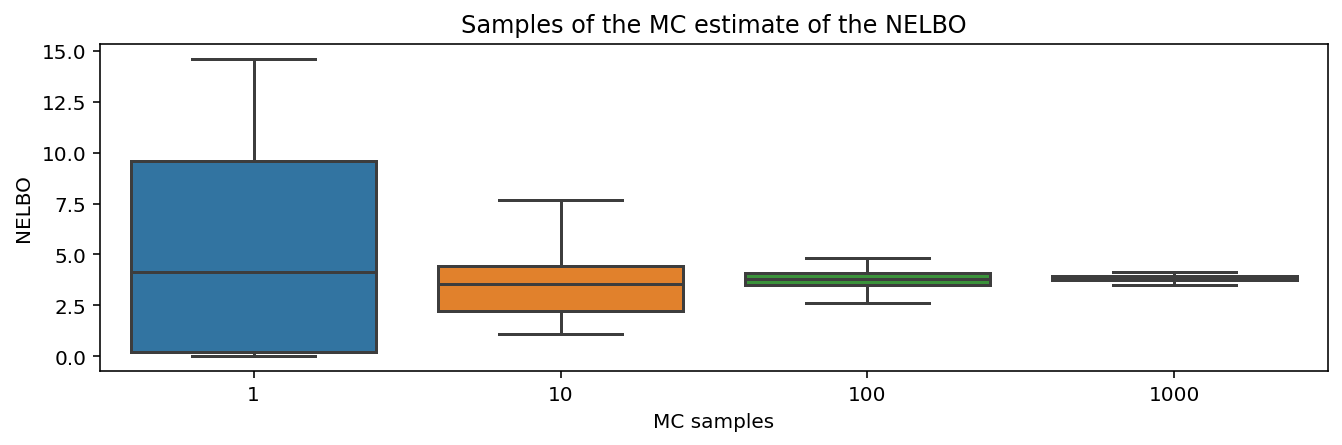

In [14]:
fig, ax = plt.subplots(figsize=[11, 3])

sns.boxplot(data=pd.DataFrame(nelbo_samples), ax=ax,  whis=np.inf)
ax.set_title('Samples of the MC estimate of the NELBO')
ax.set_xlabel('MC samples')
ax.set_ylabel('NELBO')
ax.margins(0,0.05)

plt.show()

We said that, in case of large datasets, this can be computationally challenging, due to the evaluation of the likelihood $N_\mathrm{MC}$ times.
But we know that the NELBO can be approximated even further using mini-batching.
Taking a random subset of data $\mathcal{B}$, the approximation becomes

\begin{align}
    \mathbb{E}_{q_{\theta}}\log p(\mathbf{y}|\mathbf{X}, \mathbf{w}) \approx \dfrac{1}{N_\mathrm{MC}} \frac{N}{|\mathcal{B}|}\sum_{\tilde{\mathbf{w}}_i\sim q_\theta} \sum_{\mathbf{X}_j, \mathbf{y}_j\sim\mathcal{B}} \log p(\mathbf{y}_j|\mathbf{X}_j, \tilde{\mathbf{w}}_i)
\end{align}

This introduces even more variance in the estimate of the NELBO but it allows to scale to (virtually) any sized dataset.
Run the next cell to create a dataset object with a minibatch size of just 1 sample. You can retrive a batch of data by calling the `next_batch()` function.

In [15]:
class Dataset():
    def __init__(self, X, y, minibatch_size):
        self.X = X
        self.y = y 
        self.minibatch_size = min(minibatch_size, len(self.X))
        self._i = 0  
    def next_batch(self):  
        if len(self.X) <= self._i + self.minibatch_size:
            shuffle = np.random.permutation(len(self.X))
            self.X = self.X[shuffle]
            self.y = self.y[shuffle]
            Xbatch = self.X[self._i:]
            ybatch = self.y[self._i:]
            self._i = 0
            return Xbatch, ybatch

        Xbatch = self.X[self._i:self._i + self.minibatch_size]
        ybatch = self.y[self._i:self._i + self.minibatch_size]
        self._i += self.minibatch_size
        return Xbatch, ybatch
    
dataset = Dataset(X, y, minibatch_size=1)

**Execise:**
Similarly as before, try to sample the NELBO 20 times with [1, 10, 100, 1000] MC samples but now fix the minibatch size to 100

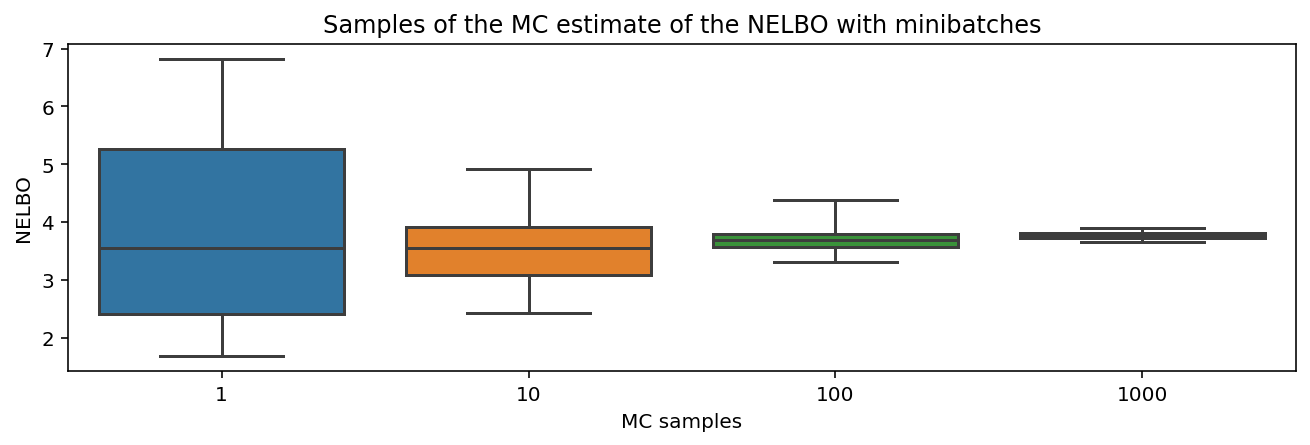

In [16]:
set_seed()

nelbo_samples = {}
num_of_nelbo_samples = 20

dataset = Dataset(X,y,minibatch_size=100)


with torch.no_grad():
    nelbo.mc_samples = 1
    nelbo_samples['1'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(dataset.next_batch()[0],dataset.next_batch()[1]).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 10
    nelbo_samples['10'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(dataset.next_batch()[0],dataset.next_batch()[1]).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 100
    nelbo_samples['100'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(dataset.next_batch()[0],dataset.next_batch()[1]).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE

    nelbo.mc_samples = 1000
    nelbo_samples['1000'] = [VariationalObjective(model,likelihood,2,nelbo.mc_samples).compute_objective(dataset.next_batch()[0],dataset.next_batch()[1]).item() for _ in range(num_of_nelbo_samples)] # TO COMPLETE
    
    

    ## *** TO COMPLETE *** ##

fig, ax = plt.subplots(figsize=[11, 3])
sns.boxplot(data=pd.DataFrame(nelbo_samples), ax=ax,  whis=np.inf )
ax.set_title('Samples of the MC estimate of the NELBO with minibatches')
ax.set_xlabel('MC samples')
ax.set_ylabel('NELBO')
ax.margins(0,0.05)
plt.show()

**Question:**
Do you see any difference? Comment the results.

# 5. Optimization

Ok, now we can move to the optimization of the NELBO. From a methodology point of view there's nothing new here: reset the gradient (required by pytorch), get a batch of data, compute the objective, backpropagate and, finally, update the parameters. 

Let's start with the binary classification dataset as it's easier to understand and plot.

**Exercise:**
Load the data from the `binaryclass2.csv` (without minibatching), create the likelihood, the model and the NELBO (use 1000 MC samples).

In [52]:
data = pd.read_csv("binaryclass2.csv") # TO COMPLETE
data = np.array(data)
X = data[...,:-1]
y = data[...,-1].reshape(-1,1)
dataset = Dataset(X, y, minibatch_size=1000)

likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(len(X[0])) ## *** TO COMPLETE *** ##

nelbo = VariationalObjective(model, likelihood, len(X[0]), mc_samples=1000)## *** TO COMPLETE *** ##

The next class is just a simple util that we will use to store some values as optimization evolves.

In [53]:
class Summary:
    @property
    def data(self):
        data = pd.DataFrame(self._data, columns=['step', self.name, 'time'])
        data.time = data.time - data.time.iloc[0]
        return data
    
    def __init__(self, name):
        """A simple class to store some values during optimization"""
        self.name = str(name)
        self._data = []
    
    def append(self, step, value):
        self._data.append([step, float(value.detach().numpy()), time.time()])

**Exercise:**
Optimize the NELBO. We suggest to use SGD optimizer the 1e-3 a learning rate (you can increase it -- if you want -- this is a simple problem). At every step, store the value of the nelbo, of the expected likelihood and the KL using the class above.

In [54]:
nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')
from IPython.display import clear_output
optim = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr=1e-2) ## *** TO COMPLETE *** ##
num_iterations = 1000

for step in range(num_iterations):
    ## *** TO COMPLETE *** ##
    optim.zero_grad()
    Xbatch, ybatch = dataset.next_batch() ## *** TO COMPLETE *** ##
    loss = nelbo.compute_objective(Xbatch, ybatch)## *** TO COMPLETE *** ##
    nelbo_summary.append(step, loss)
    
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())
    
    # Backpropagate the loss
    loss.backward()
    # Update the parameters 
    optim.step()
    # Print the current loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(step, num_iterations, loss.item()))
    ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##

Epoch [0/1000], Loss: 3.5978
Epoch [1/1000], Loss: 3.4221
Epoch [2/1000], Loss: 3.6881
Epoch [3/1000], Loss: 3.4255
Epoch [4/1000], Loss: 3.4443
Epoch [5/1000], Loss: 3.2982
Epoch [6/1000], Loss: 3.3100
Epoch [7/1000], Loss: 3.1862
Epoch [8/1000], Loss: 3.2225
Epoch [9/1000], Loss: 3.1522
Epoch [10/1000], Loss: 3.0243
Epoch [11/1000], Loss: 2.9749
Epoch [12/1000], Loss: 2.9950
Epoch [13/1000], Loss: 2.8207
Epoch [14/1000], Loss: 2.7357
Epoch [15/1000], Loss: 2.7867
Epoch [16/1000], Loss: 2.7466
Epoch [17/1000], Loss: 2.5924
Epoch [18/1000], Loss: 2.1857
Epoch [19/1000], Loss: 2.4375
Epoch [20/1000], Loss: 2.3374
Epoch [21/1000], Loss: 2.3415
Epoch [22/1000], Loss: 2.3291
Epoch [23/1000], Loss: 2.3344
Epoch [24/1000], Loss: 2.2935
Epoch [25/1000], Loss: 2.2231
Epoch [26/1000], Loss: 2.0415
Epoch [27/1000], Loss: 2.0400
Epoch [28/1000], Loss: 1.8473
Epoch [29/1000], Loss: 1.9110
Epoch [30/1000], Loss: 1.7921
Epoch [31/1000], Loss: 1.6497
Epoch [32/1000], Loss: 1.7776
Epoch [33/1000], Los

Epoch [287/1000], Loss: 0.0484
Epoch [288/1000], Loss: 0.0489
Epoch [289/1000], Loss: 0.0506
Epoch [290/1000], Loss: 0.0521
Epoch [291/1000], Loss: 0.0682
Epoch [292/1000], Loss: 0.0453
Epoch [293/1000], Loss: 0.0460
Epoch [294/1000], Loss: 0.0400
Epoch [295/1000], Loss: 0.0466
Epoch [296/1000], Loss: 0.0418
Epoch [297/1000], Loss: 0.0392
Epoch [298/1000], Loss: 0.0401
Epoch [299/1000], Loss: 0.0520
Epoch [300/1000], Loss: 0.0468
Epoch [301/1000], Loss: 0.0421
Epoch [302/1000], Loss: 0.0501
Epoch [303/1000], Loss: 0.0439
Epoch [304/1000], Loss: 0.0401
Epoch [305/1000], Loss: 0.0489
Epoch [306/1000], Loss: 0.0356
Epoch [307/1000], Loss: 0.0396
Epoch [308/1000], Loss: 0.0489
Epoch [309/1000], Loss: 0.0397
Epoch [310/1000], Loss: 0.0435
Epoch [311/1000], Loss: 0.0373
Epoch [312/1000], Loss: 0.0414
Epoch [313/1000], Loss: 0.0501
Epoch [314/1000], Loss: 0.0414
Epoch [315/1000], Loss: 0.0479
Epoch [316/1000], Loss: 0.0369
Epoch [317/1000], Loss: 0.0358
Epoch [318/1000], Loss: 0.0363
Epoch [3

Epoch [579/1000], Loss: 0.0141
Epoch [580/1000], Loss: 0.0152
Epoch [581/1000], Loss: 0.0144
Epoch [582/1000], Loss: 0.0144
Epoch [583/1000], Loss: 0.0143
Epoch [584/1000], Loss: 0.0117
Epoch [585/1000], Loss: 0.0137
Epoch [586/1000], Loss: 0.0157
Epoch [587/1000], Loss: 0.0145
Epoch [588/1000], Loss: 0.0131
Epoch [589/1000], Loss: 0.0136
Epoch [590/1000], Loss: 0.0137
Epoch [591/1000], Loss: 0.0128
Epoch [592/1000], Loss: 0.0163
Epoch [593/1000], Loss: 0.0149
Epoch [594/1000], Loss: 0.0145
Epoch [595/1000], Loss: 0.0156
Epoch [596/1000], Loss: 0.0145
Epoch [597/1000], Loss: 0.0184
Epoch [598/1000], Loss: 0.0165
Epoch [599/1000], Loss: 0.0121
Epoch [600/1000], Loss: 0.0151
Epoch [601/1000], Loss: 0.0136
Epoch [602/1000], Loss: 0.0143
Epoch [603/1000], Loss: 0.0121
Epoch [604/1000], Loss: 0.0137
Epoch [605/1000], Loss: 0.0137
Epoch [606/1000], Loss: 0.0130
Epoch [607/1000], Loss: 0.0136
Epoch [608/1000], Loss: 0.0135
Epoch [609/1000], Loss: 0.0116
Epoch [610/1000], Loss: 0.0137
Epoch [6

Epoch [868/1000], Loss: 0.0100
Epoch [869/1000], Loss: 0.0080
Epoch [870/1000], Loss: 0.0080
Epoch [871/1000], Loss: 0.0083
Epoch [872/1000], Loss: 0.0087
Epoch [873/1000], Loss: 0.0097
Epoch [874/1000], Loss: 0.0073
Epoch [875/1000], Loss: 0.0087
Epoch [876/1000], Loss: 0.0082
Epoch [877/1000], Loss: 0.0091
Epoch [878/1000], Loss: 0.0090
Epoch [879/1000], Loss: 0.0094
Epoch [880/1000], Loss: 0.0077
Epoch [881/1000], Loss: 0.0079
Epoch [882/1000], Loss: 0.0076
Epoch [883/1000], Loss: 0.0087
Epoch [884/1000], Loss: 0.0084
Epoch [885/1000], Loss: 0.0078
Epoch [886/1000], Loss: 0.0082
Epoch [887/1000], Loss: 0.0083
Epoch [888/1000], Loss: 0.0084
Epoch [889/1000], Loss: 0.0091
Epoch [890/1000], Loss: 0.0088
Epoch [891/1000], Loss: 0.0073
Epoch [892/1000], Loss: 0.0078
Epoch [893/1000], Loss: 0.0086
Epoch [894/1000], Loss: 0.0079
Epoch [895/1000], Loss: 0.0077
Epoch [896/1000], Loss: 0.0117
Epoch [897/1000], Loss: 0.0078
Epoch [898/1000], Loss: 0.0083
Epoch [899/1000], Loss: 0.0077
Epoch [9

**Exercise:**
Assess convergence of the optimization by plotting the tree metrics (plot the expected_loglik and the KL in a different plot, in logscale).

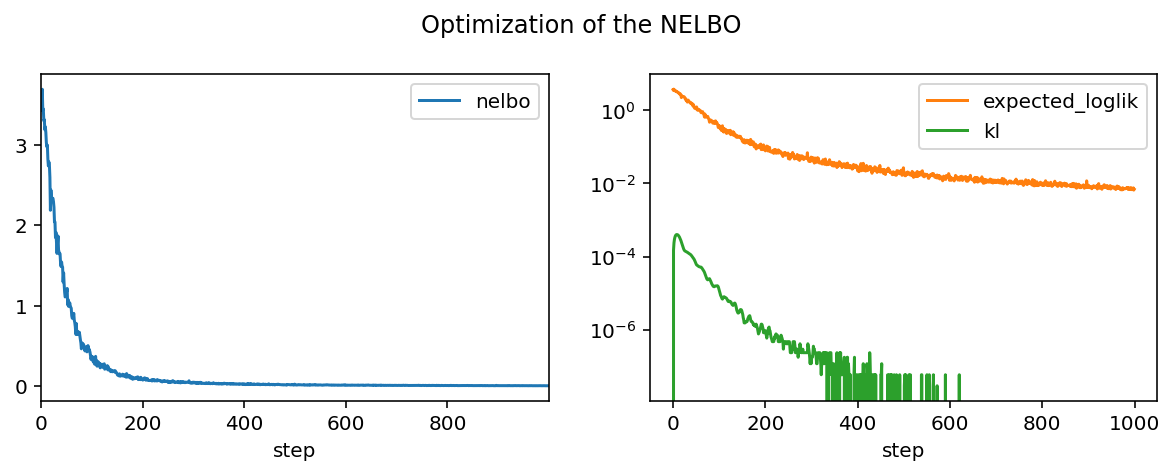

In [55]:
fig, axs = plt.subplots(1, 2, figsize=[10, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=axs[0]);
nll_summary.data.plot(x='step', y='expected_loglik', ax=axs[1], c='C1');
kl_summary.data.plot(x='step', y='kl', ax=axs[1], c='C2');
axs[1].semilogy();
fig.suptitle('Optimization of the NELBO', y=1.02)
axs[0].margins(0, 0.05)

**Question:**
Analyze the behaviour of these three values and comment the plots. Focus you analysis on the breakdown of the NELBO in its constituents parts.

the nelbo is decreasing as we wanted (our goal was to minimize it as it is our loss function). This means the prediction tends to the wanted values (the prior).

the expected loglik is and the kl are converging toward the same value (this is also what we're looking for as their differnce corresponds to the nelbo that we wish to tend toward zero.

**Exercise:**
Now the predictions! 
\begin{equation}
\mathbb{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y})}h(\mathbf{w}^\top\mathbf{x}_\mathrm{new}) = \int h(\mathbf{w}^\top\mathbf{x}_\mathrm{new}) p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \mathrm{d}\mathbf{w}
\end{equation}

With 100 samples, compute the probability $P (y_\mathrm{new} = 1 | \mathbf{x}_\mathrm{new}, \mathbf{X}, \mathbf{y})$ when $\mathbf{x}_\mathrm{new} = [2,-4]^\top$ (check the method `predict_y` of `model` and use at least 100 samples). Compare the result with the number you got from the previous lab.

**NB:** By default, PyTorch always allocates memory and computations for the gradients. For inference, this is not needed -- hence the use of `with torch.no_grad()` (It's a context-manager that disabled gradient calculation).

In [56]:
X_new= np.array([[2,-4]])
with torch.no_grad():
    n_samples = 100
    prediction = (1/n_samples) * torch.sum(model.predict_y(X_new, n_samples),dim=0).detach().numpy()
    ## *** TO COMPLETE *** ##
print(prediction)

[[0.14947565]]


**Execise:**
Let's now plot the distribution at convergence and the predictions on a grid of points. Compare it with the MCMC samples of the previous lab (you can find them in `./mcmc_samples.npy`). 

In [57]:
def plot_gaussian_pdf(distr, ax=None):
    ax = plt.gca() if ax is None else ax
    x_grid = np.linspace(0, 3, 100)
    xx, yy = np.meshgrid(x_grid, x_grid)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    m = distr.mean.detach().numpy()[...,0]
    c = distr.logvar.exp().detach().numpy() * np.eye(2)
    rv = scipy.stats.multivariate_normal(mean=m, cov=c)
    points = rv.pdf(Xplot)
    ax.contour(xx, yy, points.reshape(*xx.shape), colors='k', linewidths=1.5, zorder=100);
    ax.set_xlabel(r'$\mathbf{w}_0$')
    ax.set_ylabel(r'$\mathbf{w}_1$')


def plot_data(X, y, fmt0='oC0', fmt1='oC1', ax=None):
    mask = y[:, 0]==1
    if ax is None:
        ax = plt.gca()
    ax.plot(X[mask, 0], X[mask, 1], fmt0, ms=7, mew=0, alpha=0.7, zorder=0)
    ax.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], fmt1, ms=7, mew=0, alpha=0.7, zorder=0)
    return ax

def get_grid():
    x_grid = np.linspace(-6, 6, 100)
    xx, yy = np.meshgrid(x_grid, x_grid)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return xx, yy, Xplot

def plot_decision_boundary(xx, yy, P, ax=None):   
    if ax is None:
        ax = plt.gca()
    levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    cs = ax.contour(xx, yy, P.reshape(*xx.shape), levels,  colors='k', linewidths=1.8, zorder=100);
    ax.clabel(cs, inline=1, fontsize=10)
    cs = ax.contourf(xx, yy, P.reshape(*xx.shape), levels, cmap='Purples_r', linewidths=0, zorder=0, alpha=0.5);
    ax.set_xlabel(r'$\mathbf{x}_0$')
    ax.set_ylabel(r'$\mathbf{x}_1$')


mcmc_samples = np.load('mcmc_samples.npy')

(10000, 1)
(10000, 2)


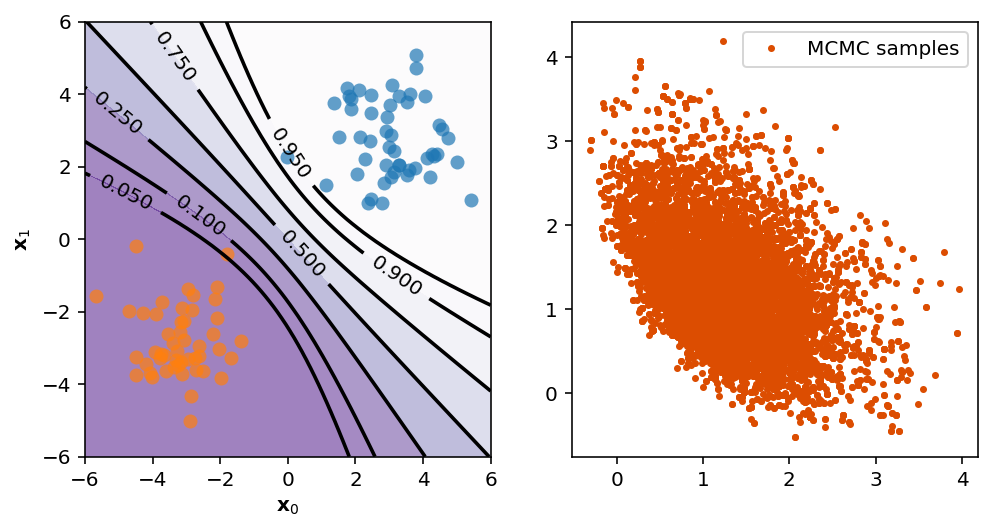

In [58]:
fig, axs = plt.subplots(1, 2, figsize=[8, 4])
xx, yy, Xplot = get_grid()

with torch.no_grad():
    #predictions = ## *** TO COMPLETE *** ##
    n_samples = 100
    predictions = (1/n_samples) * torch.sum(model.predict_y(Xplot, n_samples),dim=0).detach().numpy()

print(np.shape(predictions))
print(np.shape(Xplot))

'''
print(len(predictions))
a=predictions.reshape((1,len(predictions)))
print(np.shape(a))
'''

plot_decision_boundary(xx, yy, predictions, ax=axs[0])

plot_data(X, y, ax=axs[0])
#plot_gaussian_pdf(model.posterior_w, axs[1])
axs[1].plot(*mcmc_samples, '.', c='xkcd:deep orange', ms=5, label='MCMC samples')
axs[1].legend()
plt.show()

**Exercise:**
At convergence, sample 1000 times the NELBO like we did before, take its negative (the ELBO) plot it with a boxplot (use `torch.no_grad()`).

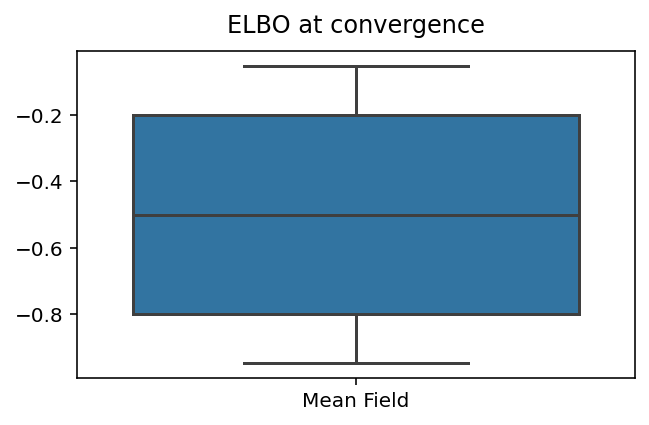

In [198]:
converged_nelbos = {}
with torch.no_grad():
    n_sampled=1000
    prediction = (1/n_samples) * torch.sum(model.predict_y(Xplot, n_samples),dim=0)
    converged_nelbos['Mean Field'] = [ -x.item() for x in prediction]## *** TO COMPLETE *** ##
    #[ - (1/n_samples) * torch.sum(model.predict_y(Xplot, n_samples),dim=0).item() for _ in range(num_of_nelbo_samples)]## *** TO COMPLETE *** ##

#print(prediction)
#print(converged_nelbos['Mean Field'] )
fig, ax = plt.subplots(figsize=[5,3])
sns.boxplot(data=pd.DataFrame(converged_nelbos),  whis=np.inf )
ax.margins(0.05)
ax.set_title('ELBO at convergence', y=1.02)
plt.show()

**(+) Exercise:** 
The powerfull aspect of (stochastic) variational inference is that it can scale very easily to any model and any-sized dataset. 
If you have time, try to solve the classification problem of the MiniBoo dataset; this dataset is taken from the MiniBooNE experiment and is used to distinguish electron neutrinos (signal) from muon neutrinos (background).

**NB:** With its more than 100000 data points each of them with 50 features, this is definetely a bigger dataset: you need to reduce the number of MC samples and the batch size.

# 6. Alternatives to Mean Field Variational Inference

As we saw from one of the previous question, the approximation that we used is very rough: it recoves some properties of the true posterior but fails to capture the strong correlation that exists in the parameter space. 
What we need to do it to increase the complexity and the expressiveness of the variational posterior. 
The first step that we can do is to introduce a non-diagonal covariance $\mathbf{w} \sim \mathcal{N}(\mu, \Sigma)$, where the covariance $\Sigma=LL^\top$ ($L$ is a lower triangular matrix).

Sampling from such distribution is possible again using the reparameterization trick,

\begin{equation}
\tilde{\mathbf{w}} = \mu + \mathrm{Tril}(L)\mathbf{\varepsilon} \quad \mathbf{\varepsilon} \sim \mathcal{N}(0, \mathrm{I})
\end{equation}

where $\mathrm{Tril}(\cdot)$ returns the lower triangular part of the matrix (the other elements are set to 0).

**Exercise:** 
Complete the next class to model a full covariance Gaussian distribution.

In [199]:
class NormalFullCovariance(Distribution): 
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalFullCovariance, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.cholesky_cov = nn.Parameter(torch.eye(d), requires_grad=train)
    
    def sample(self, n=3):
        eps = torch.randn(n,self.d,requires_grad=False)  ### torch.normal(0,1, size = (n,self.d))A TESTER AVEC TORCH.NO
        print(np.shape(self.mean))
        print(np.shape(self.cholesky_cov))
        print(eps)
        samples = self.mean + eps*self.cholesky_cov
        return samples

Now we need to compute the KL divergence between $q$ Gaussian with full covariance and $p$ Gaussian with diagonal covariance. 
Remember that the expression of the KL divergence between multivariate Gaussians $q = \mathcal{N}(\mathbf{\mu}_q, \Sigma_q)$ and $p = \mathcal{N}(\mathbf{\mu}_p, \Sigma_p)$ is as follows:

\begin{equation}
\mathrm{KL}[q || p] = 
\frac{1}{2} \mathrm{Tr}(\Sigma_p^{-1} \Sigma_q)
+ \frac{1}{2} (\mu_p - \mu_q)^{\top} \Sigma_p^{-1} (\mu_p - \mu_q)
- \frac{D}{2} 
+ \frac{1}{2} \log\left( \frac{\mathrm{det}\Sigma_p}{\mathrm{det}\Sigma_q} \right)
\end{equation}

**Question:**
Given that $q = \mathcal{N}(\mathbf{\mu}_q, LL^\top)$ and $p = \mathcal{N}(\mathbf{\mu}_p, \sigma^2_p\mathrm{I})$, write the simplified KL divergence. 

*Hints:* 

- $\mathrm{Tr}(LL^\top) = \sum\mathrm{diag}(L)^2$ 

- $\log\mathrm{det}(LL^\top) = \sum\log\mathrm{diag}(L)^2$


Below, you'll find the KL implemented. 

In [409]:
@register_kl(NormalFullCovariance, NormalDiagonal)
def _kl_normalfullcov_normaldiagonal(q, p):
    kl = (
        torch.sum(p.logvar.exp() * torch.diag(q.cholesky_cov)**2) + 
        torch.sum(p.logvar.exp() * (p.mean - q.mean) ** 2) +
        torch.sum(p.logvar) + 
        torch.sum(torch.log(torch.diag(q.cholesky_cov)) ** 2) -
        len(q.mean)
    )
    return .5 * kl

KL divergence between 'NormalFullCovariance' and 'NormalDiagonal' registered.


**Exercise:**
Now we need to modify the logistic regression model by using the new `NormalFullCovariance` as posterior over $\mathbf{w}$. Complete the next class.

In [410]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.prior_w = NormalDiagonal(input_dim) ## *** TO COMPLETE *** ##
        self.posterior_w = NormalFullCovariance(input_dim) ## *** TO COMPLETE *** ##
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1):
        w_samples = self.posterior_w.sample(mc_samples) ## *** TO COMPLETE *** ##
        w_samples=torch.unsqueeze(w_samples, dim=2)
        y_samples = logistic( X@ w_samples) ## *** TO COMPLETE *** ##
        return y_samples

Done! If you did everything correctly you don't need to change anything more.

**Exercise:**
Train this new model exactly the same as before. Plot the progression of the NELBO.

In [24]:
likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(len(X[0])) ## *** TO COMPLETE *** ##

nelbo = VariationalObjective(model, likelihood, len(X[0]), mc_samples=1000)## *** TO COMPLETE *** ##

In [25]:
nelbo_summary = Summary('nelbo')

optim = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr=1e-3) ## *** TO COMPLETE *** ##
num_iterations = 1000
dataset = Dataset(X, y, minibatch_size=10)
for step in range(num_iterations):
    ## *** TO COMPLETE *** ##
    
    #nelbo_summary.append(step, loss)
    
    ## *** TO COMPLETE *** ##

    ## *** TO COMPLETE *** ##
    optim.zero_grad()
    Xbatch, ybatch = dataset.next_batch() ## *** TO COMPLETE *** ##
    loss = nelbo.compute_objective(Xbatch, ybatch)## *** TO COMPLETE *** ##
    
    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())
    
    # Backpropagate the loss
    loss.backward()
    # Update the parameters 
    optim.step()
    # Print the current loss
    clear_output(True) #clear the previous output
    print(step, loss)
    ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##

999 tensor(0.6287, grad_fn=<AddBackward0>)


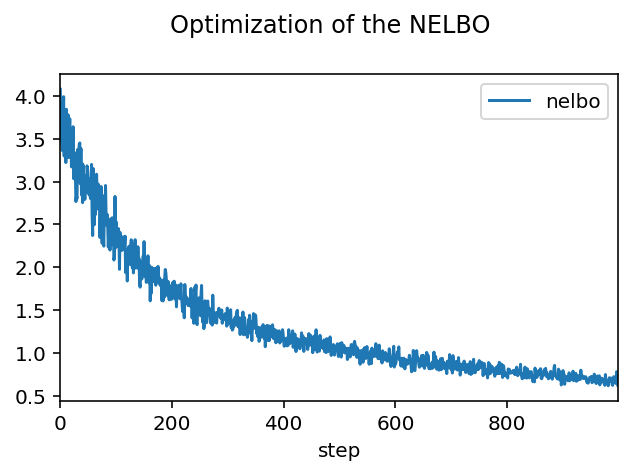

In [26]:
fig, ax = plt.subplots(figsize=[5, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=ax);
fig.suptitle('Optimization of the NELBO', y=1.02)
ax.margins(0, 0.05)

**Exercise:**
Do the same plot as before, by showing predictions and distribution (together with MCMC samples).

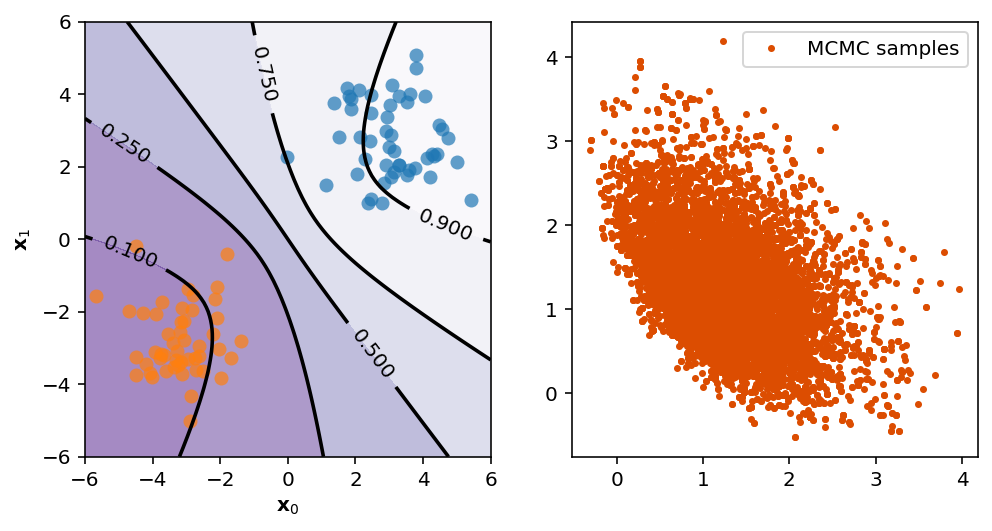

In [27]:
def plot_gaussian_pdf(distr, ax=None):
    ax = plt.gca() if ax is None else ax
    x_grid = np.linspace(0, 3, 100)
    xx, yy = np.meshgrid(x_grid, x_grid)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    m = distr.mean.detach().numpy()
    c = distr.cholesky_cov.detach().numpy()
    c = c @ c.T
    rv = scipy.stats.multivariate_normal(mean=m, cov=c)
    points = rv.pdf(Xplot)
    ax.contour(xx, yy, points.reshape(*xx.shape), colors='k', linewidths=1.5, zorder=100);
    ax.set_xlabel(r'$\mathbf{w}_0$')
    ax.set_ylabel(r'$\mathbf{w}_1$')


fig, axs = plt.subplots(1, 2, figsize=[8, 4])
xx, yy, Xplot = get_grid()

with torch.no_grad():
    #predictions = ## *** TO COMPLETE *** ##
    n_samples = 100
    predictions = (1/n_samples) * torch.sum(model.predict_y(Xplot, n_samples),dim=0).detach().numpy()

plot_decision_boundary(xx, yy, predictions, ax=axs[0])
plot_data(X, y, ax=axs[0])
## *** TO COMPLETE *** ##

axs[1].plot(*mcmc_samples, '.', c='xkcd:deep orange', ms=5, label='MCMC samples')
axs[1].legend()
plt.show()

**Exercise:**
As before sample 1000 times the NELBO, take its negative (the ELBO) plot it with a boxplot, together with the previous one.

In [28]:
with torch.no_grad():
    converged_nelbos['Full Cov'] = ## *** TO COMPLETE *** ##
    
fig, ax = plt.subplots(figsize=[5,3])
sns.boxplot(data=pd.DataFrame(converged_nelbos),  whis=np.inf, linewidth=.75)
ax.margins(0.05)
ax.set_title('ELBO at convergence', y=1.02)
plt.show()

SyntaxError: invalid syntax (<ipython-input-28-685bb65dc9f9>, line 2)

**Question:**
Do you observe something interesting? 
Remember what the ELBO represents. It is the lower bound of the marginal distribution $p(\mathbf{y}|\mathbf{X})$. Check the first lab on Bayesian linear regression if you don't remember what the marginal distribution measures. Based solely on this value, which model would you choose? Why?    